In [1]:
import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import pandas as pd
import setigen
import os
import turbo_seti
%matplotlib inline

import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find
from turbo_seti.find_doppler.find_doppler import FindDoppler
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

numexpr.utils   INFO     Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [2]:
csv_file = '/home/cgchoza/galaxies/complete_cadences_catalog.csv'

df = pd.read_csv(csv_file)
dfl = df.iloc[np.where(df['Band'].values == 'L')[0]]

del df

In [3]:
#dfl

,Target,Session,Band,Cadence ID,Frequency,.h5 path,.dat path,Time
0,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
1,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
2,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
3,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
4,DDO210,AGBT18A_999_103,L,24777,2251,/datag/pipeline/AGBT18A_999_103/collate/splice...,/home/obs/turboseti/AGBT18A_999_103/collate/sp...,2018-07-07 08:49:26
...,...,...,...,...,...,...,...,...
36553,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36554,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36555,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36
36556,NGC3226,AGBT22B_999_25,L,411390,1126,/datag/pipeline/AGBT22B_999_25/blc16_blp06/blc...,/home/obs/turboseti/AGBT22B_999_25/blc16_blp06...,2022-11-19 06:13:36


In [ ]:
# fix for unspliced cadences — every 6 rows?

In [50]:
for ii in range(len(dfl['Cadence ID'].values)//6):

    cadence_id = dfl['Cadence ID'].values[ii*6]

    #if ii < 6:
    #    print('File already done!')
    #    continue

    target = dfl['Target'].values[np.where(dfl['Cadence ID'].values == cadence_id)[0]][0]
    #if target != 'NGC7640':
    #    continue

    print('==========')
    print(f'Cadence ID {cadence_id}:')

    dat_list = dfl['.dat path'].values[ii*6:ii*6+6]
    h5_list = dfl['.h5 path'].values[ii*6:ii*6+6]

    node = os.path.basename(h5_list[0])[:5]

    # alphabetize to get correct order for FindEvent
    # don't forget to grab .dat files in /datax/scratch/benjb/ and not /datag/
  
    # This writes the .h5 files into a .lst, as required by the find_event_pipeline:
    h5_list_path = os.path.join('/datax/scratch/benjb/C23_L_dats/C23_L_lsts', f'{cadence_id}_{target}_{node}_h5_files.lst')
    with open(h5_list_path, 'w') as f:
        for h5_path in h5_list:
            f.write(h5_path + '\n')

    # You don't have to print, but it's a good way to check that your list is in the correct order:
    with open(h5_list_path, 'r') as f:
        print(f.read())

    # This writes the .dat files into a .lst, as required by the find_event_pipeline:
    dat_list_path = os.path.join('/datax/scratch/benjb/C23_L_dats/C23_L_lsts', f'{cadence_id}_{target}_{node}_dat_files.lst')

    with open(dat_list_path, 'w') as f:
        for ii, dat_path in enumerate(dat_list):
            if ii%2 == 0: # ONs
                if os.path.isfile('/datax/scratch/benjb/C23_L_dats/' + os.path.basename(dat_path)): # check to make sure the file exists (if it doesn't, no hits were deleted from it)
                    print('ON file exists!')
                    f.write('/datax/scratch/benjb/C23_L_dats/' + os.path.basename(dat_path) + '\n')
                else:
                    print('ON file does not exist; grabbing old one.')
                    f.write(dat_path + '\n')
            else:         # OFFs
                f.write(dat_path + '\n')

    # You don't have to print, but it's a good way to check that your list is in the correct order:
    with open(dat_list_path, 'r') as f:
        print(f.read())

    csvf_path = f'/datax/scratch/benjb/C23_L_dats/{cadence_id}_{target}_{node}_found_event_table_3.csv'

    find_event_pipeline(dat_list_path, 
                    h5_list_path,
                    #SNR_cut=2,
                    check_zero_drift=True,
                    filter_threshold = 3, 
                    number_in_cadence = len(dat_list),
                    csv_name=csvf_path, 
                    saving=True
                    )

    #break


Cadence ID 47043:
/datag/pipeline/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_08450_NGC7640_0033.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_08767_HIP115723_0034.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_09084_NGC7640_0035.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_09400_HIP115106_0036.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_10034_HIP115708_0038.gpuspec.0000.h5

ON file exists!
ON file exists!
ON file does not exist; grabbing old one.
/datax/scratch/benjb/C23_L_dats/blc71_guppi_58832_08450_NGC7640_0033.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_08767_HIP115723_0034.gpuspec.0000/blc71_guppi_58832_08767_HIP115723_0034.gpuspec.0000.dat
/datax/scratch/benjb/C23_L_dats/blc71_guppi_58832_09084_NGC7640_0035.gpuspec.

In [6]:
#event_df = pd.read_csv('/datax/scratch/benjb/C23_L_dats/DDO210_f3_snrNone_zero.csv')

In [35]:
#event_df

,Unnamed: 0,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,38,39,-0.004938,13.087125,2223.152282,696276,2223.152282,2223.152282,9,1,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_38,on_table_1,2.0,0,0.0
1,1803,41,-0.004938,13.687256,2223.152277,696278,2223.152277,2223.152277,9,1,...,-12.8477,18.253611,-2.793968,4.0,584.115552,DDO210_38,on_table_2,NaN,0,1244.0
2,3432,32,-0.004938,32.954437,2223.152271,696280,2223.152271,2223.152271,9,1,...,-12.8477,18.253611,-2.793968,4.0,584.115552,DDO210_38,on_table_3,NaN,0,2488.0
3,386,418,3.994472,10.999968,1621.123339,164172,1621.123339,1621.123339,215,1,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_386,on_table_1,2.0,0,0.0
4,2123,400,-3.959910,10.142573,1621.124937,163600,1621.124937,1621.124937,215,1,...,-12.8477,18.253611,-2.793968,4.0,584.115552,DDO210_386,on_table_2,NaN,0,1244.0
5,3623,274,-2.295958,44.912807,1621.134028,160346,1621.134028,1621.134028,215,1,...,-12.8477,18.253611,-2.793968,4.0,584.115552,DDO210_386,on_table_3,NaN,0,2488.0
6,413,460,-2.715649,28.688183,1618.354897,106460,1618.354897,1618.354897,216,1,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_413,on_table_1,2.0,0,0.0
7,2153,443,0.967758,11.333396,1618.352712,107242,1618.352712,1618.352712,216,1,...,-12.8477,18.253611,-2.793968,4.0,584.115552,DDO210_413,on_table_2,NaN,0,1244.0
8,3646,301,-1.397325,33.940002,1618.346258,109552,1618.346258,1618.346258,216,1,...,-12.8477,18.253611,-2.793968,4.0,584.115552,DDO210_413,on_table_3,NaN,0,2488.0
9,652,908,0.004938,330.958221,1537.072463,887024,1537.072463,1537.072463,243,1,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_652,on_table_1,2.0,0,0.0


In [26]:
#event_df[::3].to_csv('/datax/scratch/benjb/C23_L_dats/DDO210_f3_test.csv')

In [27]:
#event_test_df = pd.read_csv('/datax/scratch/benjb/C23_L_dats/DDO210_f3_test.csv')

In [28]:
#event_test_df

,Unnamed: 0,Unnamed: 0.1,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,0,38,39,-0.004938,13.087125,2223.152282,696276,2223.152282,2223.152282,9,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_38,on_table_1,2.0,0,0.0
1,3,386,418,3.994472,10.999968,1621.123339,164172,1621.123339,1621.123339,215,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_386,on_table_1,2.0,0,0.0
2,6,413,460,-2.715649,28.688183,1618.354897,106460,1618.354897,1618.354897,216,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_413,on_table_1,2.0,0,0.0
3,9,652,908,0.004938,330.958221,1537.072463,887024,1537.072463,1537.072463,243,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_652,on_table_1,2.0,0,0.0
4,12,1108,1470,-0.291315,29.244993,1206.849434,589362,1206.849434,1206.849434,356,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_1108,on_table_1,2.0,0,0.0
5,15,1374,1738,-0.009875,13.448346,1188.004546,1042754,1188.004546,1188.004546,362,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_1374,on_table_1,2.0,0,0.0
6,18,1514,1888,3.643907,74.620560,876.407237,370143,876.407237,876.407237,469,...,-12.8485,18.253611,-2.793968,4.0,584.115552,DDO210_1514,on_table_1,2.0,0,0.0


plot_event_pipeline: Opened file /datax/scratch/benjb/C23_L_dats/DDO210_f3_test.csv
plot_event_pipeline: file = spliced_blc0001020304050607_guppi_58306_31766_DDO210_0002.gpuspec.0000.h5, tstart = 58306.36766203704, source_name = DDO210
plot_event_pipeline: file = spliced_blc0001020304050607_guppi_58306_32388_DDO210_off_0003.gpuspec.0000.h5, tstart = 58306.37486111111, source_name = DDO210_off
plot_event_pipeline: file = spliced_blc0001020304050607_guppi_58306_33010_DDO210_0004.gpuspec.0000.h5, tstart = 58306.382060185184, source_name = DDO210
plot_event_pipeline: file = spliced_blc0001020304050607_guppi_58306_33632_DDO210_off_0005.gpuspec.0000.h5, tstart = 58306.38925925926, source_name = DDO210_off
plot_event_pipeline: file = spliced_blc0001020304050607_guppi_58306_34254_DDO210_0006.gpuspec.0000.h5, tstart = 58306.396458333336, source_name = DDO210
plot_event_pipeline: file = spliced_blc0001020304050607_guppi_58306_34876_DDO210_off_0007.gpuspec.0000.h5, tstart = 58306.403657407405, so

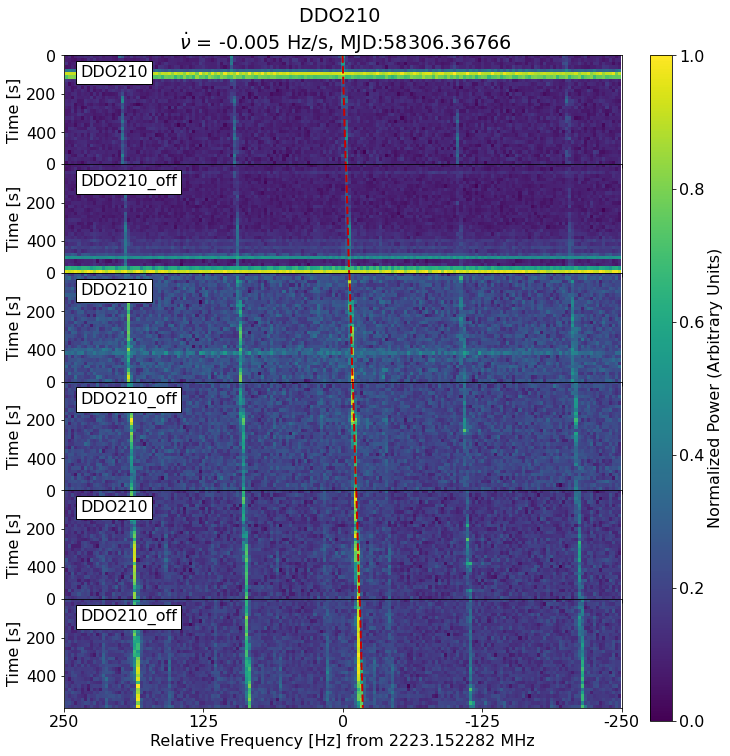

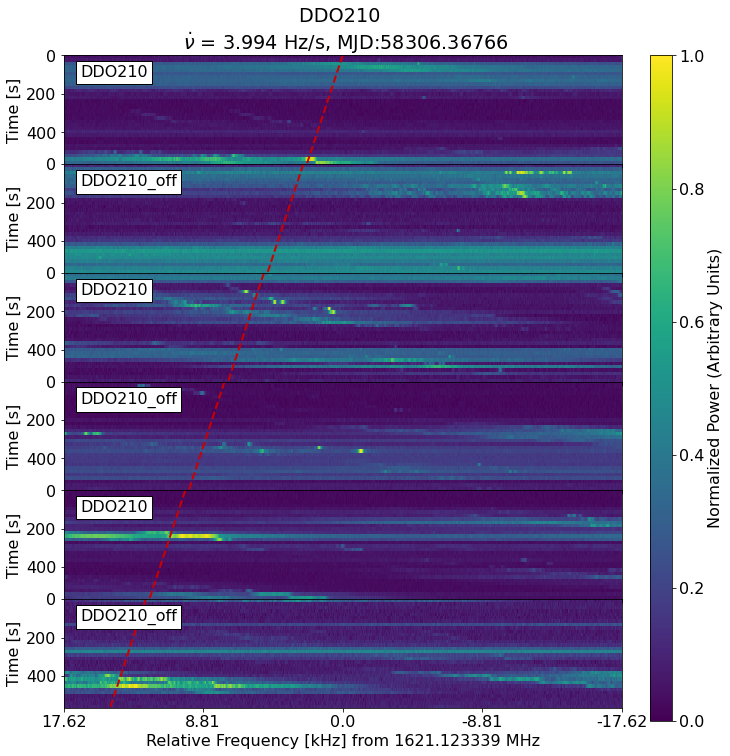

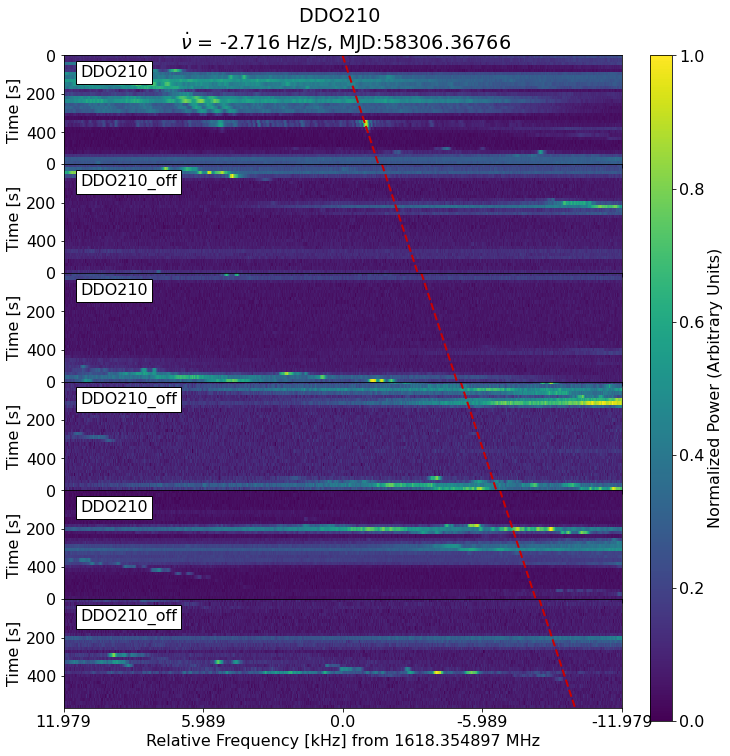

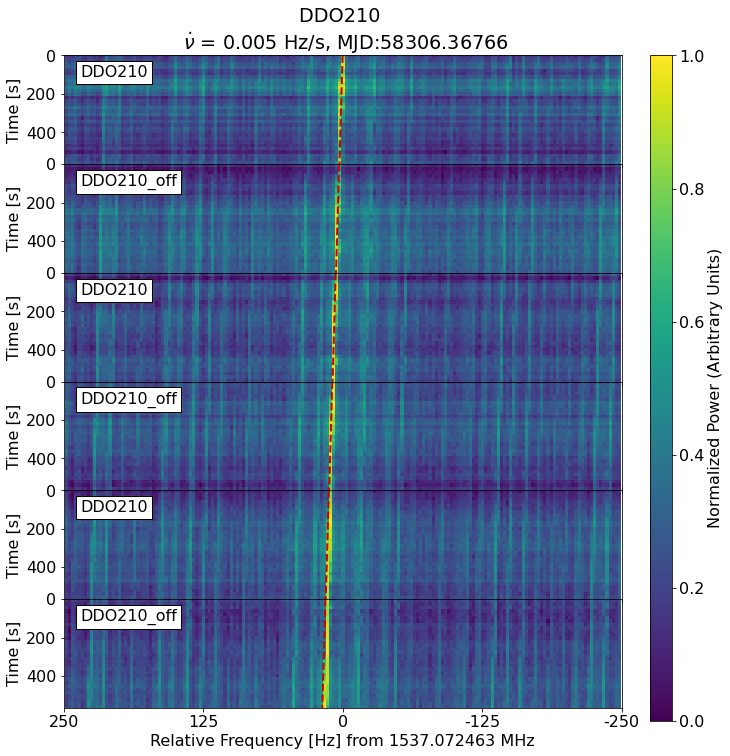

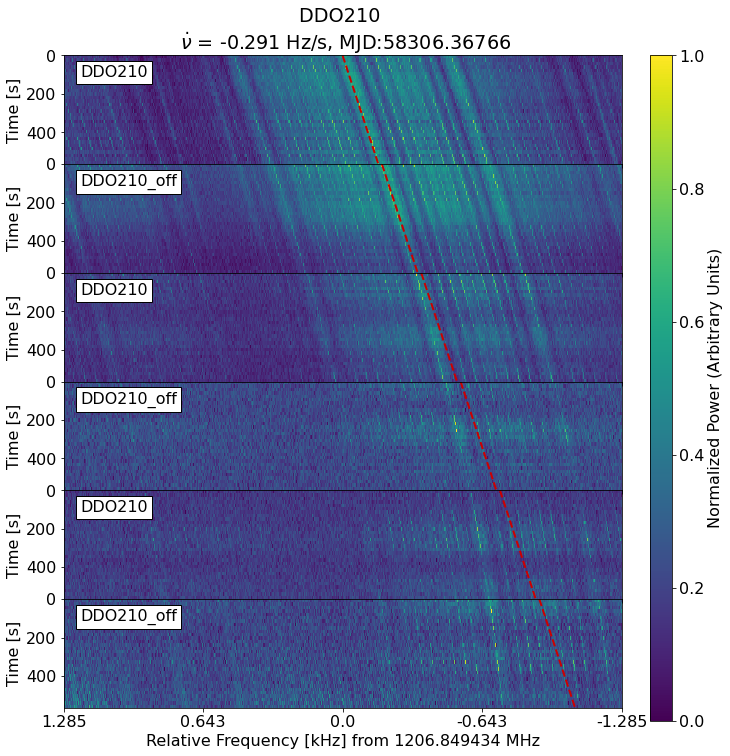

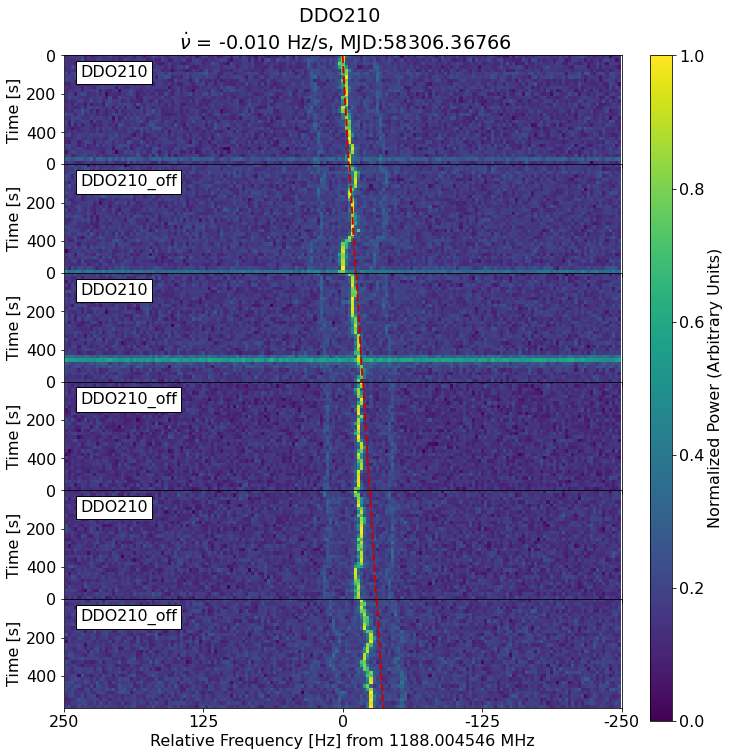

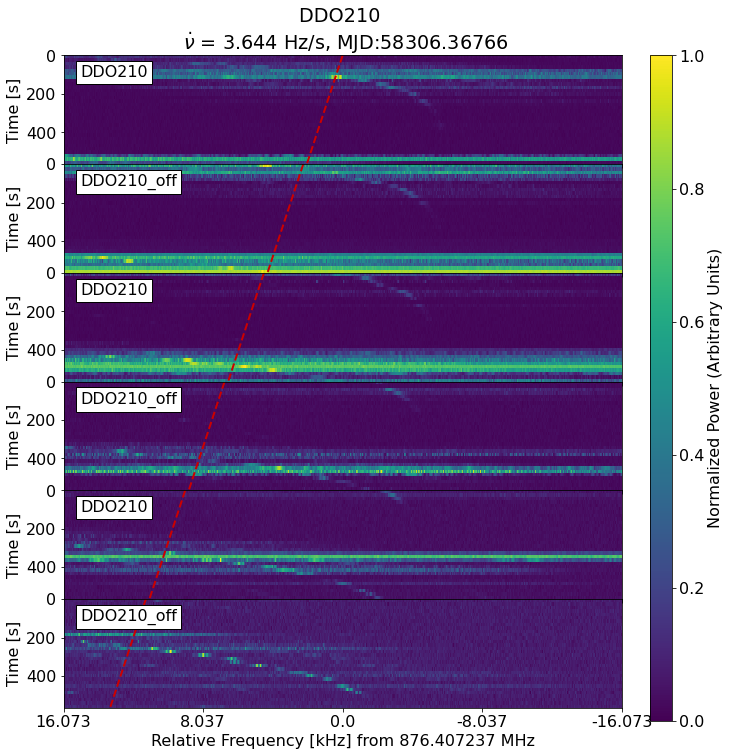

plot_event      INFO     plot_candidate_events: elapsed time = 339.22 seconds


In [29]:
#csvf_path = '/datax/scratch/benjb/C23_L_dats/DDO210_f3_test.csv'

#plot_event_pipeline(csvf_path, # full path of the CSV file built by find_event_pipeline()
#                    h5_list_path, # full path of text file containing the list of .h5 files
#                    filter_spec='f{}'.format(3), # filter threshold
#                    user_validation=False, # Non-interactive
#                    plot_dir='/datax/scratch/benjb/C23_L_pngs/') 

In [44]:
event_csv = '/home/cgchoza/BL-TESSsearch/analysis/event_data.csv'

df = pd.read_csv(event_csv)
df = df.iloc[np.where(df['Band'].values == 'L')[0]]
df = df[df['Hit_ID'].str.contains('PEGASUS')]

In [45]:
df

,Unnamed: 0,Unnamed: 0.1,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,...,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t,Band,FilePath
24,0,761,762,0.004938,625.221252,1536.069182,197537,1536.069182,1536.069182,133,...,-2.793968,4.0,584.115552,PEGASUS_761,on_table_1,2.0,0,0.0,L,/home/obs/events/24868/1926/found_event_table.csv
25,1,3950,772,0.004938,794.596741,1536.069190,197534,1536.069190,1536.069190,133,...,-2.793968,4.0,584.115552,PEGASUS_761,on_table_2,NaN,0,1248.0,L,/home/obs/events/24868/1926/found_event_table.csv
26,2,5466,721,0.009875,502.848938,1536.069196,197532,1536.069196,1536.069196,133,...,-2.793968,4.0,584.115552,PEGASUS_761,on_table_3,NaN,0,2496.0,L,/home/obs/events/24868/1926/found_event_table.csv
27,3,773,774,0.004938,36.349575,1533.560039,47018,1533.560039,1533.560039,134,...,-2.793968,4.0,584.115552,PEGASUS_773,on_table_1,2.0,0,0.0,L,/home/obs/events/24868/1926/found_event_table.csv
28,4,3963,785,0.004938,39.097588,1533.560048,47015,1533.560048,1533.560048,134,...,-2.793968,4.0,584.115552,PEGASUS_773,on_table_2,NaN,0,1248.0,L,/home/obs/events/24868/1926/found_event_table.csv
29,5,5478,733,0.004938,30.693790,1533.560053,47013,1533.560053,1533.560053,134,...,-2.793968,4.0,584.115552,PEGASUS_773,on_table_3,NaN,0,2496.0,L,/home/obs/events/24868/1926/found_event_table.csv


In [20]:
#print(sorted(event_df['Unnamed: 0'].values))
#print(sorted(np.unique([s[7:] for s in (df['Hit_ID'].values)]).astype('int')))

[38, 386, 413, 652, 1108, 1374, 1514, 1803, 2123, 2153, 2511, 2943, 3006, 3178, 3432, 3623, 3646, 3846, 3976, 3996, 4070]
[38, 459, 1469, 1737, 1887]


In [5]:
#print(len(np.unique(df['Hit_ID'].values)))

400


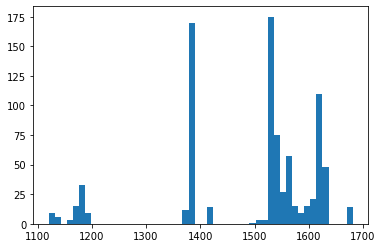

In [17]:
#plt.hist(df['Freq'].values[np.where((df['Freq'].values > 1100) & (df['Freq'].values < 1200) | 
#                                        (df['Freq'].values > 1340) & (df['Freq'].values < 1900))], bins=50)
#plt.show()

In [7]:
#len(np.unique(df['Hit_ID'].values[np.where((df['Freq'].values > 1100) & (df['Freq'].values < 1200) | 
#                                        (df['Freq'].values > 1340) & (df['Freq'].values < 1900))]))

288

In [ ]:
# should be 288